**Automated Parameter Selection**: Auto-ARIMA, on the other hand, automates the process of selecting the order of the ARIMA model.
- Search Algorithm: Auto-ARIMA typically employs a search algorithm that explores different combinations of AR, I, and MA orders to find the model with the lowest Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
- Ease of Use: Auto-ARIMA is user-friendly and requires less manual intervention compared to traditional ARIMA. It is suitable for users who are less familiar with time series analysis.

# Preprocessing

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pmdarima.arima import auto_arima

In [3]:
# import data
df = pd.read_csv('df_post_eda.csv')

In [4]:
pred_var = 'Additional_Doses_Vax_Pct'
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()
df = pd.DataFrame(df)
df.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,10.332812
2021-11-10,13.185937
2021-11-17,15.871875
2021-11-24,18.675000
2021-12-01,20.689062


In [6]:
# Scale data -> some % columns, some raw number columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,0.000000
2021-11-10,0.070026
2021-11-17,0.135949
2021-11-24,0.204748
2021-12-01,0.254180


In [7]:
train_size = int(len(df_scaled) * 0.7625)
train, test = df_scaled[0:train_size], df_scaled[train_size:]
print(train.shape, test.shape)

(61, 1) (19, 1)


# Model Building

#### No Tuning of Auto-ARIMA

In [27]:
model = auto_arima(train, start_p=0, start_d=0, start_q=0,
                   max_p=5, max_d=5, max_q=5, 
                   start_P=0, start_D=0, start_Q=0,
                   max_P=5, max_D=5, max_Q=5, m=12,
                   seasonal=True, error_action='warn', stepwise=True,
                   suppress_warnings=True, trace=True, random_state=45,
                  n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-422.034, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-424.844, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-424.468, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-423.808, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-422.859, Time=0.35 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-422.812, Time=0.11 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-424.527, Time=0.08 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-420.904, Time=0.36 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-423.070, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=-422.906, Time=0.16 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-422.056, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-424.006, Time=0.06 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-420.921, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-425.204, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0

In [32]:
seasonal = model.get_params()['seasonal_order']
order = model.get_params()['order']
seasonal

(1, 0, 0, 12)

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Best hyperparameters
p, d, q = 0, 2, 1
P, D, Q, S = 1, 0, 0, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.531121
         Iterations: 2
         Function evaluations: 122
Training RMSE: 0.010981423610464548
Testing RMSE: 0.005517790178342288


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


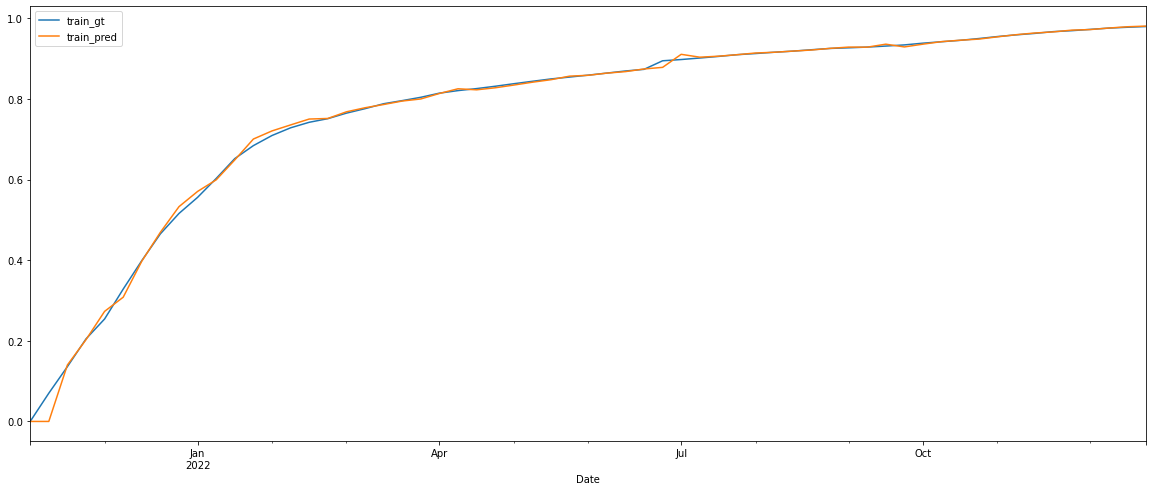

In [24]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

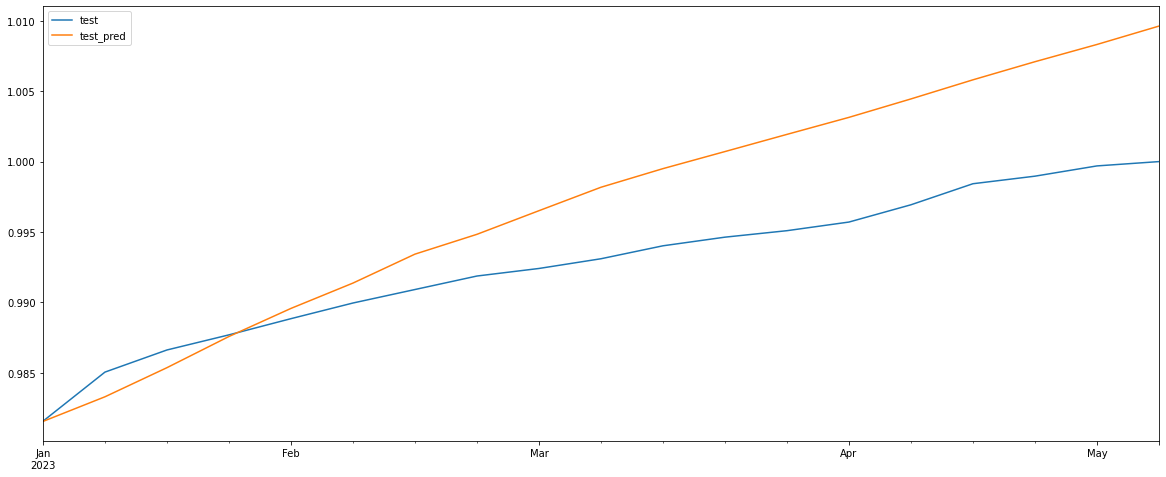

In [25]:
pd.concat([test, test_pred_mean], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

### Attempting to Tune Auto-ARIMA 

In [36]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt


# Define the range of hyperparameters for the grid search
p_values = range(1, 4)
d_values = range(1, 4)
q_values = range(1, 4)
P_values = range(1, 4)
D_values = range(1, 4)
Q_values = range(1, 4)
S_values = [12] 

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size = 4, gap = 3)  # Adjust the number of splits as needed
best_test_rmse = float('inf')
best_params = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for S in S_values:
                            test_rmse_values = []
                            
                            for train_index, test_index in tscv.split(train):
                                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]
                                
                                # Train auto-ARIMA model
                                model = auto_arima(train_fold, start_p=0, start_d=0, start_q=0,
                                                  max_p=p, max_d=d, max_q=q,
                                                  start_P=0, start_D=0, start_Q=0,
                                                  max_P=P, max_D=D, max_Q=Q, m=12,
                                                seasonal=True, error_action='warn', stepwise=True,
                                                suppress_warnings=True, trace=True, random_state=45, n_fits=50)
                                
                                seasonal = model.get_params()['seasonal_order']
                                order = model.get_params()['order']
                                
                                auto_model = SARIMAX(train_fold, order=order, seasonal_order=seasonal)
                                fit_model = auto_model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')
                                
                                # make predictions on test set
                                test_fold_pred = fit_model.get_forecast(steps=len(test_fold)).predicted_mean
                                
                                # calc rmse for test fold
                                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                                test_rmse_values.append(test_fold_rmse)
                                
                                # calc avg test RMSE across cross-validation folds
                                avg_test_rmse = np.mean(test_rmse_values)
                                
                                # update best order if current combo has lower average test RMSE
                                if avg_test_rmse < best_test_rmse:
                                    best_test_rmse = avg_test_rmse
                                    best_params = (p, d, q, P, D, Q, S)
                                    

print(f"Best SARIMAX Parameters: {best_params}")
print(f"Lowest Test RMSE: {best_test_rmse}")                

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.979 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] interce

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-335.510, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-335.651, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-335.606, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.57 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.809 seconds
Optimization terminated successfully.
         Current function value: -3.248016

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.56 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.87 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.57 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.97

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.85 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.483215
         Iterations: 4
         Function evaluations: 256
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.59 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.09 sec

Best model:  ARIMA

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.64 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.88 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.48

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.913 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-335.510, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-335.651, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-335.606, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.660 seconds
Optimization terminated successfully.
         Current function value: -3.248016

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.51 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.43 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.80

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.46 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=1.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.54

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.60 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.802 seconds
Optimization terminated successfully.
         Current function value: -3.248016

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.43 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=1.08

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.38 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=1.00 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.52 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.483215
         Iterations: 4
         Function evaluations: 256
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.937 seconds
Optimization terminated successfully.
         Current function value: -3.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.694 seconds
Optimization terminated successfully.
         Current function value: -3.248016

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.45 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.78

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.47

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.717 seconds
Optimization terminated successfully.
         Current function value: -3.248016

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.62 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.82 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.42 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=1.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.63

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.73 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.643 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.99 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.72 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.40 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=1.04

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.93 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.60 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.743 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.58 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.60 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.73 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=1.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.47 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=1.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.52

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.75 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.62 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.546 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.57 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.99 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.68 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.50 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.78 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.51

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.66 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.578 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performi

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.59 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.57 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.89

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.70 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.54 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.461 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.88 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.68 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.61 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.88 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.33 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.42 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.85 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.67 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.57 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.451 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.57 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=1.14 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.60 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.38 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.82 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.50

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.75 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.682 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performi

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.69 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=1.13 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.64 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.34

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.73 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.55 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.502 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=1.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.52 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.55 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.62 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.55 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.26 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.58 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.47 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.217 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.57 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.461 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.56 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.81 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.06

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.32

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.65 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.53 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.325 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.56 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.50 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.82 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.353 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.54 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.50

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.480 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performi

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.90

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.57 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.348 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.97 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.60 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.48

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.73 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.56 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.539 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.530 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.27 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.94

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.58 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.266 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.56 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.71 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.59 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.53 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.315 seconds
Optimization 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.81 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.47 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-247.927, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.79 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.899 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-335.510, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-335.651, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-335.606, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.32 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.54 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.692 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.69 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.42 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.78

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.48 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.650 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.50 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.44 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.78

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.49 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.900 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-335.510, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-335.651, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-335.606, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.33 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.50 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.649 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.51 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.71 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.41 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.78

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.47 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.38 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.59 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.20 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.953 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.69 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.79 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.52 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.46 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.883 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-335.510, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-335.651, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-335.606, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.30 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.24 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.50 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.628 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.71 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.46 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.66 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.902 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.55 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.81 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.53 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=1.00

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.56 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.498 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.86 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.57 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.395504
         Iterations: 4
         Function evaluations: 250
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.32 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.19 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.94 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.53 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.297 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.52 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.63 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.48 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.81 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.517 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.78 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.55 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.27 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.91 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.37 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.96 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.48 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.483215
         Iterations: 4
         Function evaluations: 256
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.495 seconds
Optimiza

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.52 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.67 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.395504
         Iterations: 4
         Function evaluations: 250
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.38 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.99 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.24 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.47 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.224 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.85 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.52 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.67 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.55 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.50 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.51 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.483215
         Iterations: 4
         Function evaluations: 256
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.72 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.60 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.42 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.81 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.63 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.72 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.612 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.95 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.58 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.66 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.395504
         Iterations: 4
         Function evaluations: 250
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=1.07 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.50 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.296 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.81 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.45 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.94 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.56 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.347 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.58 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.98 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.39 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.35 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.78 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.58 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.65 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.569 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.69 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.33 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.94 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.49 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.279 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.62 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.395504
         Iterations: 4
         Function evaluations: 250
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.63 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.96 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.35 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.81 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.56 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.67 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.54 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.445 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.59 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.521 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.50 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.56 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.89 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.315 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.47 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.47 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.296 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.91 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.56 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.36 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.521 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.75 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.56 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.395504
         Iterations: 4
         Function evaluations: 250
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.92 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.324 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.59 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.52 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.87 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.38 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.48 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.88 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.69 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.799 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=1.18 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.58 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.69 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.52 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.64 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.78 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.65 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.15

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.905 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.31 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.48 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.651 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.50 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.49 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.97

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.79 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.46 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.668 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.71 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.93 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.65 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.89

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.35 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.87 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.49 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.935 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.32 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.42 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.63 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.958 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.51 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.95 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.46 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.77

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.58 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.53 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.754 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.76 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-333.005, Time=0.44 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=-330.996, Time=0.93

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.35 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.93 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.47 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 0.898 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=-206.411, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-368.139, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-367.950, Time=0.04 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.33 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.696 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.61 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.47 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=1.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.52 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.665 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-270.229, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-166.289, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-269.083, Time=0.10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-301.964, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-187.587, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-304.320, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.395504
         Iterations: 4
         Function evaluations: 250
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.54 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.82 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.93 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.49 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-166.233, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.69 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.606 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.84 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.61 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=1.01 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.49 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.246 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.51 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.68 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.78 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.46

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.27 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.48 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.258 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.18 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.49 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.516 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.80 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.55 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.35 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.87 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.298 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.59 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.32 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.51 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.49 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.276 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.54 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.12

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.51 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.16

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.55 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.82 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.724 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.55 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.92 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.07

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.48 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.285 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.53 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.71 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.53 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.14 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.51 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.260 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.78 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.55 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.48 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-363.633, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-362.611, Time=0.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-362.415, Time=0.79 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=-364.026, Time=0.48

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 1.509 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function evaluations: 102
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-185.895, Time=0.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=0.77 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.11

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-333.000, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-334.736, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.32 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.948, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-366.499, Time=0.25 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-247.262, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-364.073, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-367.252, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-366.257, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-361.863, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-367.269, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-364.839, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=-363.360, Time=0.97 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-231.137, Time=0.08

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-191.947, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-142.241, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-238.945, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-238.118, Time=0.70 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-238.242, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-240.105, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-236.989, Time=0.30 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-235.351, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-239.596, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-238.923, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,1)[12] intercept
Total fit time: 2.651 seconds
Optimization terminated successfully.
         Current function value: -3.248016
         Iterations: 2
         Function e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.430, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-215.058, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-162.002, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-269.462, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-269.067, Time=0.51 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-267.860, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-271.202, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-267.729, Time=1.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-183.898, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-269.670, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-214.236, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-272.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-271.804, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-269.932, Time=0.49 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-270.414, Time=0.13

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-303.229, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-239.418, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-182.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-300.335, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-300.305, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-300.094, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-302.244, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-299.488, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-204.021, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-301.326, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-238.425, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-303.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-297.991, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=-302.175, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=-302.333, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-226.612, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-331.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-263.983, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-202.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-331.614, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-329.038, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-332.187, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-334.153, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=-331.740, Time=0.52 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-330.179, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-225.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.879, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=-334.962, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-334.900, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-289.645, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-223.431, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-363.215, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-361.163, Time=0.32 sec


KeyboardInterrupt: 

### Tuning SARIMAX Model

In [64]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
S_values = [12] 

In [65]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming 'train' and 'test' are your time series training and testing sets

best_test_rmse = float('inf')
best_params = None

for p, d, q, P, D, Q, S in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values):
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
    fit_model = model.fit(disp=False)

    # Make predictions on the test set
    test_pred = fit_model.get_forecast(steps=len(test)).predicted_mean

    # Calculate RMSE for the test set
    test_rmse = sqrt(mean_squared_error(test, test_pred))

    # Update best parameters if current combination has lower test RMSE
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        best_params = (p, d, q, P, D, Q, S)

print(f"Best SARIMAX Parameters: {best_params}")
print(f"Lowest Test RMSE: {best_test_rmse}")

Best SARIMAX Parameters: (2, 1, 1, 0, 0, 2, 12)
Lowest Test RMSE: 0.0010052369133782078


In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Best hyperparameters
p, d, q = 2, 1, 1
P, D, Q, S = 0, 0, 2, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.557890
         Iterations: 4
         Function evaluations: 377
Training RMSE: 0.010938884668406224
Testing RMSE: 0.0018469419277994954


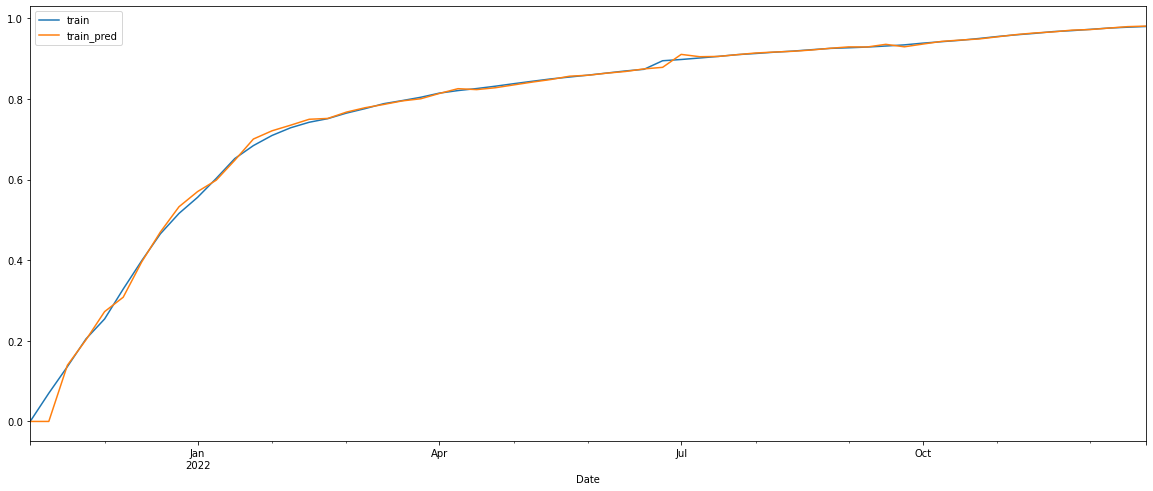

In [72]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

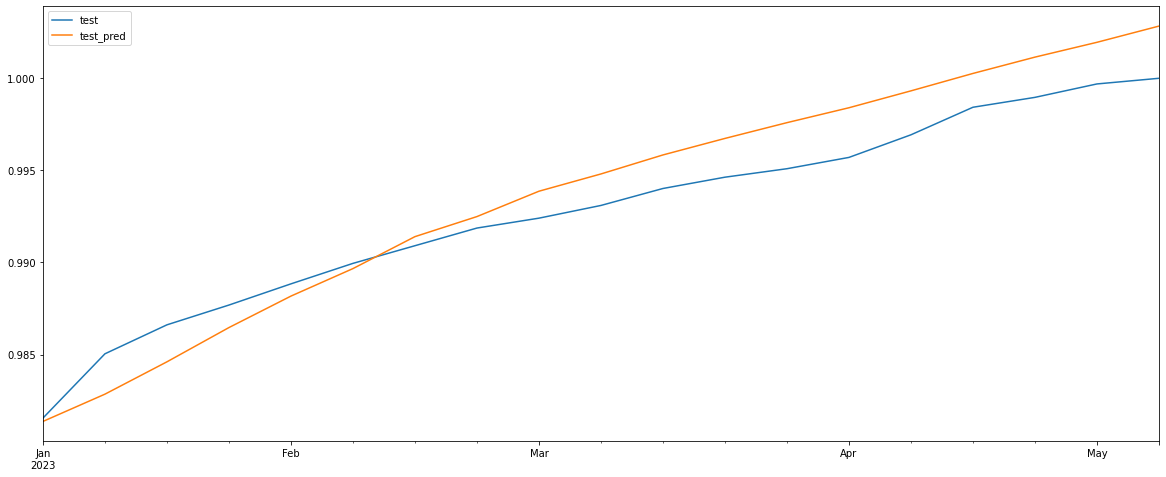

In [73]:
pd.concat([test, test_pred_mean], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

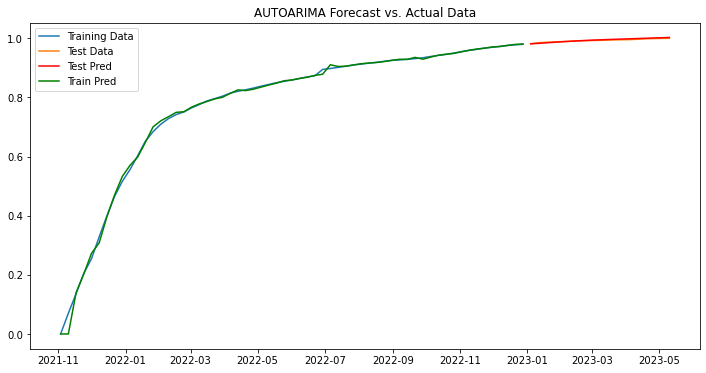

In [74]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred_mean, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()